This is just going to train a simple model using the converted images.
I'm now following the 7th lesson of fastai which covers this as well.

This time I am going to flatten the input images with an initial layer.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import SaveModelCallback
from tqdm import tqdm_notebook as tqdm
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
label_pattern = r'/([^/]+)_\d+.jpg$'
BATCH_SIZE=128
defaults.cmap='binary'

In [4]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(
    path=TRAIN_FOLDER,
    fnames=get_image_files(TRAIN_FOLDER),
    pat=label_pattern,
    ds_tfms=([*rand_pad(padding=3, size=28, mode='zeros')], []),
    bs=BATCH_SIZE,
).normalize()

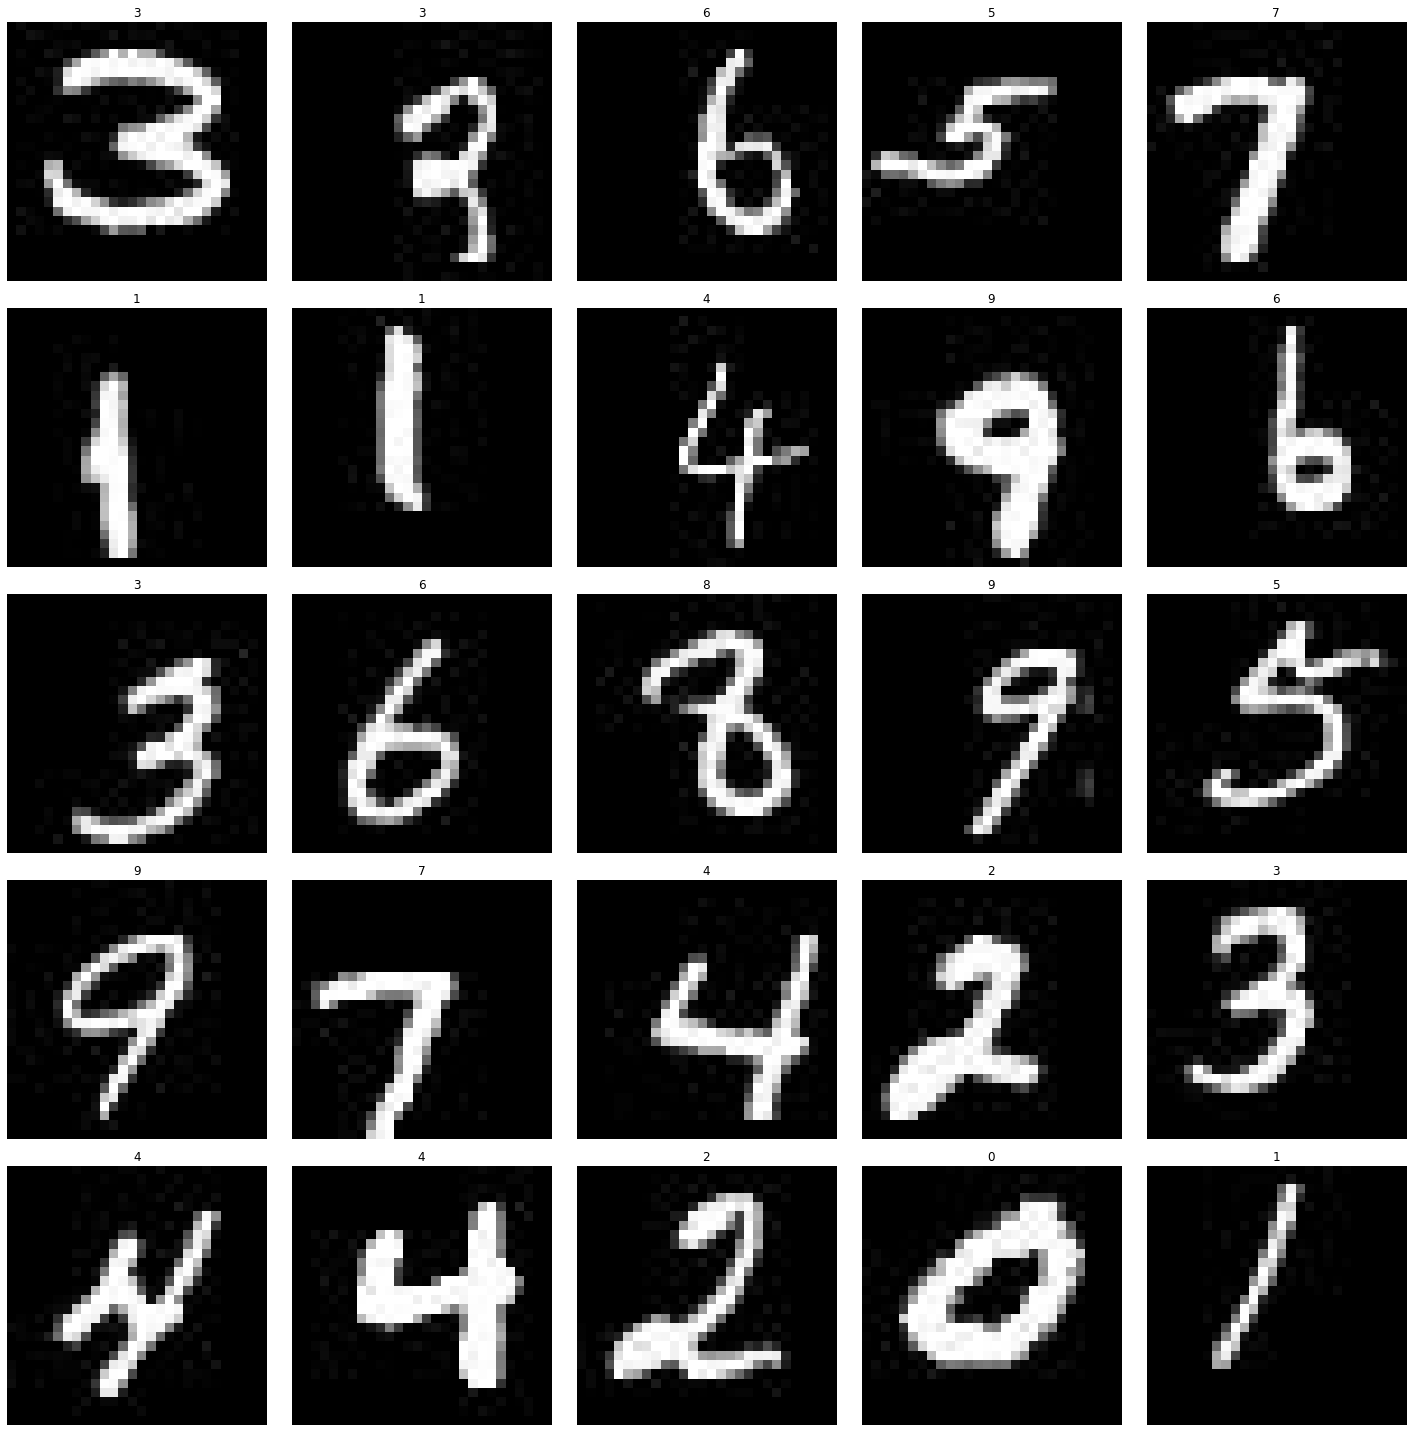

In [5]:
data.show_batch()

### With Flattening

I now want to create this same model but with an initial layer that will flatten the three channels.
Taking the maximum of the three values should be fine.
I need to practice this first.

In [8]:
data.train_ds[0]

(Image (3, 28, 28), Category 2)

In [9]:
data.train_ds[0][0]

In [16]:
image = data.train_ds[0][0]

In [22]:
image.px[0] + image.px[1] + image.px[2]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0118, 0.0235, 0.0000, 0.0000, 0.0588, 0.0000, 0.0235, 0.0118, 0.0000,
         0.0000, 0.0000, 0.0118, 0.0471, 0.0471, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
         0.1059, 0.1059, 0.0000, 0.0000, 0.0235, 0.0118, 0.0000, 0.0000, 0.0824,
         0.1059, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0824, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0118, 0.0118, 0.0000, 0.1176, 0.0471, 0.0000,
         0.0000, 0.0235, 0.0471, 0.0588, 0.0706, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.0471,
         0.0000, 0.0000, 0.0706, 0.0353, 0.0000, 0.0235, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0353, 0.0235, 0.0000, 0.0000, 0.0000

In [33]:
image.px.max(0, keepdim=True)[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0039, 0.0078, 0.0000, 0.0000, 0.0196, 0.0000, 0.0078,
          0.0039, 0.0000, 0.0000, 0.0000, 0.0039, 0.0157, 0.0157, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0039, 0.0353, 0.0353, 0.0000, 0.0000, 0.0078, 0.0039, 0.0000,
          0.0000, 0.0275, 0.0353, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0275,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0000, 0.0392,
          0.0157, 0.0000, 0.0000, 0.0078, 0.0157, 0.0196, 0.0235, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0235,
          0.0157, 0.0000, 0.0000, 0.0235, 0.0118, 0.0000, 0.0078, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0118, 0.0078, 0.0000,

In [40]:
image.px.max(0, keepdim=True)[0].shape

torch.Size([1, 28, 28])

In [6]:
class Max(nn.Module):
    """ (3,28,28) -> (1,28,28) """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.max(1, keepdim=True)[0] # it is dimension 1 now because 0 is the batch

In [7]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [8]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [9]:
model = nn.Sequential(
    Max(),
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [10]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [46]:
learn.fit_one_cycle(10, max_lr=0.1)

In [47]:
learn.save('05-custom-model-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


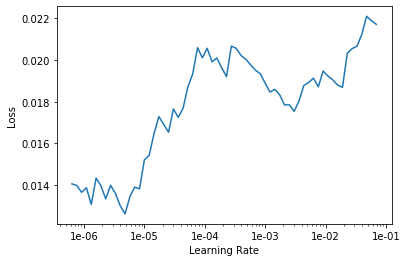

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(25, max_lr=0.1)

In [50]:
learn.save('05-custom-model-2')

### Submission

After repeated training this is clearly closer than the original model.
I can submit this and see how well I did.

In [12]:
from src.models.predict_model import submission

In [13]:
learn.load('05-custom-model-2')
df = submission(learn, TEST_FOLDER)

100%|██████████| 28000/28000 [02:53<00:00, 160.92it/s]


In [14]:
df.head()

Label
ImageId      
1           2
2           0
3           9
4           0
5           3

In [15]:
df.to_csv(SUBMISSION_CSV)

was: `1686 Matthew Franglen 0.98271`<br/>
was: `0731 Matthew Franglen 0.99428`<br/>
now: `0694 Matthew Franglen 0.99457`

Further progress is likely to be limited so lets try with a better model architecture.